[View in Colaboratory](https://colab.research.google.com/github/spectrmen/mashine-leaning/blob/master/fases_recognation.ipynb)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage import data, color, feature, transform
import skimage.data

# Распознование лиц методом HOG


In [3]:
from sklearn.datasets import fetch_lfw_people
faces=fetch_lfw_people()
positive_patches=faces.images # картинки с лицами

imgs_to_use=['camera', 'text', 'coins', 'moon',
            'page', 'clock', 'immunohistochemistry',
            'chelsea', 'coffee', 'hubble_deep_field']
images=[color.rgb2gray(getattr(data, name)())
       for name in imgs_to_use]


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [4]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0,
                   patch_size=positive_patches[0].shape):
    extracted_patch_size= \
    tuple((scale*np.array(patch_size)).astype(int))
    extractor=PatchExtractor(patch_size=extracted_patch_size,
                            max_patches=N, random_state=0)
    patches=extractor.transform(img[np.newaxis])
    if scale!=1:
        patches=np.array([transform.resize(patch, patch_size)
                         for patch in patches])
        
    return patches

negative_patches= np.vstack([extract_patches(im, 1000, scale)
                            for im in images for scale in [0.5, 1.0, 2.0]]) # картинки без лиц

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
from itertools import chain
X_train = np.array([feature.hog(im)
                   for im in chain(positive_patches,
                                  negative_patches)])

y_train=np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]]=1  #помечаем картинки с лицами


/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [6]:
from sklearn.svm import LinearSVC  # Обучаем модель svc на hog признаках
from sklearn.grid_search import GridSearchCV
grid =GridSearchCV(LinearSVC(), {'C':[1.0, 2., 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.9863530173709898

In [7]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(-0.5, 139.5, 159.5, -0.5)

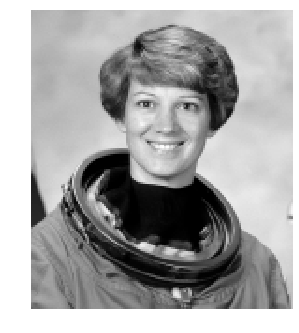

In [8]:
test_image = skimage.data.astronaut() # тестовое лицо
test_image=skimage.color.rgb2gray(test_image)
test_image =skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [12]:
# создадим окно, которое будет искать лицо

def sliding_window(img, patch_size=positive_patches[0].shape,
                  istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            
            if scale !=1:
                patch =transform.resize(patch, patch_size)
            yield(i, j), patch
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape
                

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1911, 1215)

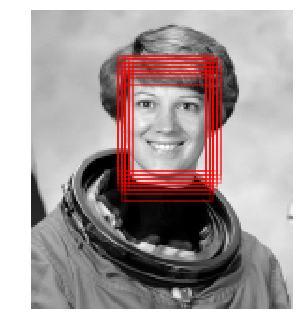

In [14]:
labels = model.predict(patches_hog)
labels.sum()

fig, ax = plt.subplots()

ax.imshow(test_image, cmap='gray')

ax.axis('off')

Ni, Nj =positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
  ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', 
                            alpha=0.3, lw=2, facecolor='none'))